# An introduction to analysing a SNOMED CT coded dataset using FHIR terminology server (Supplement)

## Introduction
Here we review an approach for anlysing a dataset containing [SNOMED CT](http://snomed.org/) and [Australian Medicines Terminology (AMT)](https://www.healthterminologies.gov.au/learn). The approach essentially consists of 3

1. Defining a set of aggregation categories, using SNOMED CT Expression Constraint Language [ECL](https://confluence.ihtsdotools.org/display/DOCECL).
2. Identify all the codes that match each category, using [Ontoserver](https://ontoserver.csiro.au/) to perform valueSet Expansions.
3. Store the results of each expansion in a Hash Set for fast lookup.
4. Use the Sets to filter our dataset, and optionally create human readable labels.
5. Use standard analytic approaches to report and visualise the data.

The dataset used was generated using [this tool](https://github.com/MattCordell/DataGenerator), and contains no real patient data.

This notebook acts as a supplementary artefact to HDA 2019 presentation of the same name. The notebook is best viewed at [http://bit.ly/SNOMED_HDA19](http://bit.ly/SNOMED_HDA19), but is also available on [github](https://github.com/MattCordell/DataAnalyticProjects/tree/master/HDA2019), along with the dataset used and original HDA 19 slides.

In [2]:
#!pip install --user --upgrade pip
import pandas as pd

#!pip install --user matplotlib-venn
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles
#Global Styling
plt.style.use('tableau-colorblind10')
plt.tight_layout()

## Importing the dataset
The dataset is imported using Pandas, with the last two columns set to string datatypes. Although not entirely necessary, the codes are really labels, and not numeric values. It also helps with some of the visuals in this notebook and JSON parsing later on.


In [3]:
codeSet = pd.read_table('SCT_HDA_2019_Dataset.txt',dtype={'Condition':str,'Medication':str})

codeSet.head(15)

,First,Last,Sex,DoB,PostCode,Condition,Medication
0,Elena,Cook,F,26/04/1998,B03,102930000,7086011000036102
1,Kaylee,Hardin,F,24/01/1953,E00,49512000,1112071000168105
2,Hinata,Shepard,M,7/09/1943,E00,277627005,5604011000036100
3,Myles,Aguilar,M,1/01/1966,E00,3109008,3231000036108
4,Alesia,Walls,F,14/02/1957,E00,723409007,6286011000036105
5,Marley,Bowen,M,14/08/1961,E00,3272007,761951000168100
6,Denise,Bullock,F,28/01/1986,C04,86225009,921045011000036104
7,Sofia,Scott,F,15/06/1983,C04,163577001,NaN
8,Cataleya,Shaw,F,23/05/1967,C04,191737008,927853011000036101
9,Bonnie,Chambers,F,29/01/1983,C04,718393002,787621000168109


**Reminder**: The data set, is a complete work of fiction, and uses **no real patient data**. Names, characters, etc are randomly generated by code. Any resemblance to actual persons, living or dead, or actual events is purely coincidental. Please see the [Readme](https://github.com/MattCordell/DataAnalyticProjects/blob/master/HDA2019/README.md) for more details.

In [4]:
#We don't need First and Last Name, along with DoB and Postcode fields for this demonstration.
#So let's just drop them.
codeSet.drop(["First", "Last","DoB", "PostCode"], axis=1,inplace=True)

#Get some basic stats
print('Number of unique Condition codes :'+str(codeSet['Condition'].nunique()))
print('Number of unique Medication codes :'+str(codeSet['Medication'].nunique()))
print('Number of Entries :'+ str(codeSet.shape[0]))


Number of unique Condition codes :24647
Number of unique Medication codes :10128
Number of Entries :500000


With almost 25 thousand Condition codes, and over 10 thousand unique medications, we really need to perform some aggregation to gain any useful insights to this data. SNOMED CT isn't designed for any specific usecase and such versatility allows us to aggregate however we want.

As explained in the introduction the approach described in this notebook relies on four things:

* Defining aggregation categories using SNOMED CT ECL.
* Identifing all the codes that match our category, using Ontoserver to perform valueSet Expansions.
* Storing the codes from each expansion in a Hash Set.
* Using these Sets to filter our dataset and optionally create human readable labels.
    
We'll be performing a lot of expansions, so to start with, let's create a function that accepts an ECL string and returns the populated set.

A complete expansion call looks something like 

`https://ontoserver.csiro.au/stu3-latest/ValueSet/$expand?url=http://snomed.info/sct?fhir_vs=ecl/<74978011000036101`

The function below takes an ECL expression, and generates a safe URL. ie. special characters in the ECL are handled.

In [5]:
#!pip install --user fhir.resources
import requests #for Rest calls

#Fhir ValueSet makes parsing the json responses easier.
from fhir.resources.valueset import ValueSet 

def PopulateSetWithECL(ecl):
    #Compose the API call.
    endpoint= "https://ontoserver.csiro.au/stu3-latest"
    expandAPI="/ValueSet/$expand"
    sctValueSetUrl='http://snomed.info/sct?fhir_vs=ecl/'    
    urlParam={'url':sctValueSetUrl+ecl}    
    
    #Execute the Get Request, and parse the JSON response to FHIR ValueSet
    response=requests.get(endpoint+expandAPI,params=urlParam)
    j=response.json()
    vs=ValueSet(j)

    #add every code to a Set
    _set=set()
    for e in vs.expansion.contains:          
        _set.add(e.code)    
    
    return _set
        
#Note: The above function is not production quality.
#In particular, the response.status_code should be checked, and pagination may be required for large value sets.       

## Defining Aggregation Categories
To Start with, let's create some general categories to see what sort of health conditions are in the datase.
Each category will be defined as a tuple consisting of the ECL defition, and a human readable label. To keep things simple, we'll the ECL definitions will just be simple Subtype (`<<`) expressions.

In [6]:
healthCategories=[
('<<106028002','Musculoskeletal problems'),
('<<106048009','Respiratory problems'),
('<<195967001','Asthma'),
('<<363346000','Cancer'),
('<<13645005','COPD'),
('<<73211009','Diabetes mellitus'),
('<<106063007','Cardiovascular problems'),
('<<249578005','Kidney problems'),
('<<74732009','Mental illness'),
('<<40733004','Infectious disease'),
('<<414022008','Blood disease')
]

Now we'll iterate through this list, performing an expansion (using the PopulateSetWithECL() function above). The entries to label can be idenfified using a simple _boolean filter_ for codes that match those in applicable Set. Each matching entry gets labeled in a new column "Category".

Once the **healthCategories** List has been processed, mark any unlabelled Categories "Other Condition"

In [7]:
#loop through the categories and label any entry that matches the healthCategory with that label.
#using simple boolean filter

for category in healthCategories:
    categorySet = PopulateSetWithECL(category[0])
    filter = codeSet["Condition"].isin(categorySet)
    codeSet.loc[filter,"Category"] = category[1]

codeSet.loc[codeSet["Category"].isnull(),"Category"] = "Other Condition"
    
codeSet.head(15)

,Sex,Condition,Medication,Category
0,F,102930000,7086011000036102,Other Condition
1,F,49512000,1112071000168105,Mental illness
2,M,277627005,5604011000036100,Cancer
3,M,3109008,3231000036108,Mental illness
4,F,723409007,6286011000036105,Kidney problems
5,M,3272007,761951000168100,Blood disease
6,F,86225009,921045011000036104,Blood disease
7,F,163577001,NaN,Other Condition
8,F,191737008,927853011000036101,Mental illness
9,F,718393002,787621000168109,Mental illness


Now we've applied some categorical labels to work with, we can generate summary of these health conditions by Sex.

In [8]:
codeSet[['Category','Sex','Condition']].groupby(['Category','Sex']).count()

Condition
Category                 Sex           
Blood disease            F         7741
                         M         3295
Cancer                   F         1909
                         M         3298
Cardiovascular problems  F        13716
                         M        10481
Diabetes mellitus        F        18463
                         M        10362
Infectious disease       F         1435
                         M          368
Kidney problems          F          531
                         M          356
Mental illness           F       106980
                         M       104910
Musculoskeletal problems F         1817
                         M         1400
Other Condition          F       107163
                         M       105340
Respiratory problems     F          230
                         M          205

## Considerations concerning disjointness and SNOMED CT polyheirarchy
At this point it's important to note that SNOMED CT is a polyheirarchy. Meaning that codes may appear in more than one lineage. This may or may or may not be of consequence, depending on what your specific use case. Considering our original categories, there's some obvious potential overlap, particularly with the very broad 'Respiratory problems' category. However a quick look at the sets as Venn diagram, shows how much overlap there really is.

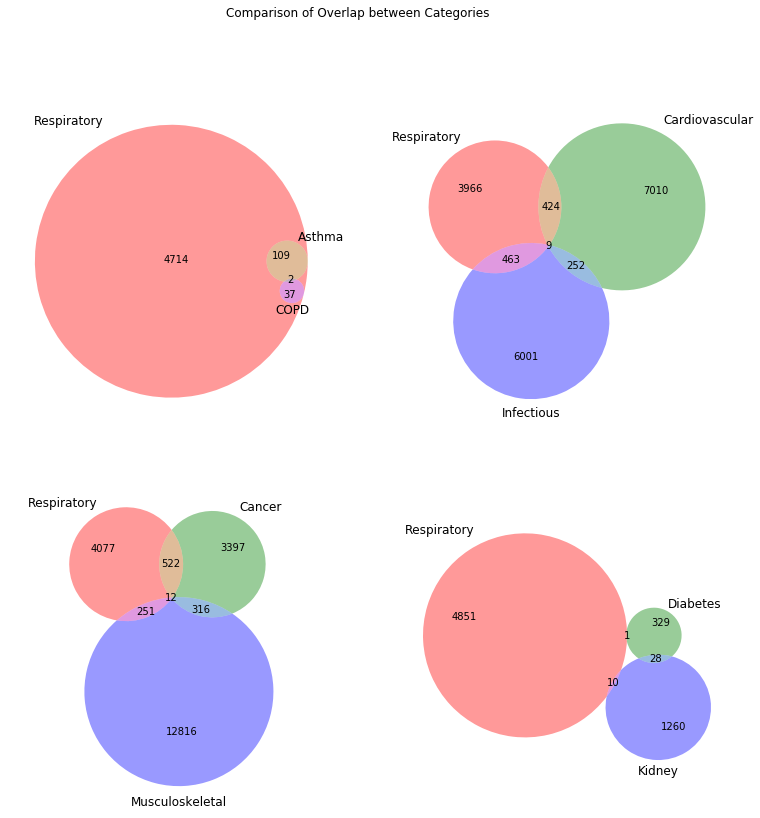

In [9]:
#Generate a few Venn Diagrams illustrating overlap with the "Respiratory" category

Respiratory = PopulateSetWithECL('<<106048009')
Asthma = PopulateSetWithECL('<<195967001')
COPD = PopulateSetWithECL('<<13645005')
Cardiovascular = PopulateSetWithECL('<<106063007')
Infectious = PopulateSetWithECL('<<40733004')
Cancer = PopulateSetWithECL('<<363346000')
Diabetes = PopulateSetWithECL('<<73211009')
Kidney = PopulateSetWithECL('<<249578005')
Musculoskeletal = PopulateSetWithECL('<<106028002')

figure, axes = plt.subplots(2, 2, figsize=(13,13))

venn3([Respiratory,Asthma,COPD],set_labels=('Respiratory','Asthma','COPD'),ax=axes[0][0])
venn3([Respiratory,Cardiovascular,Infectious],set_labels=('Respiratory','Cardiovascular','Infectious'),ax=axes[0][1])
venn3([Respiratory,Cancer,Musculoskeletal],set_labels=('Respiratory','Cancer','Musculoskeletal'),ax=axes[1][0])
venn3([Respiratory,Diabetes,Kidney],set_labels=('Respiratory','Diabetes','Kidney'),ax=axes[1][1])
figure.suptitle("Comparison of Overlap between Categories")

plt.show()

The approach so far has categorised the conditions in the sequence as they appear in the List; such that conditions matching later categories will be over-riden. Conversely, the labels _could_ be applied only to 'unlabled' episodes, such that episodes are labeled in order of priority and not overridden.

It is also possible to build disjointness into the categories using ECL, if required. For example:

_Respiratory problems excluding Cancer, Musculoskeletal and infectious disorders_ could be specified as:

`<<106048009|Respiratory| minus (<<363346000|Cancer| OR  <<106028002|Musculoskeletal|OR <<40733004|Infectious)`

The approach taken, depends on the analytics use case and wether or not it's acceptable to "double count" episodes. Let's look at the diabetes patients a little more closely.

Number of Diabetes mellitus episodes : 28825
Number of Type 1 DM episodes : 14648
Number of Type 2 DM episodes : 13215
Number of DM during pregnancy episodes : 1464
Number of Gestational diabetes mellitus episodes : 26
Number of Pre-existing DM in pregnancy episodes : 716
Sum of all the counted episodes : 30069


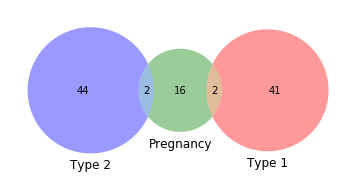

In [10]:
DiabetesEpisodes=codeSet[codeSet["Category"]=='Diabetes mellitus'].copy()
print("Number of Diabetes mellitus episodes : " + str(DiabetesEpisodes.shape[0]))

DiabetesCategories=[
('<<46635009','Type 1 DM'),
('<<44054006','Type 2 DM'),
('<<199223000','DM during pregnancy'),
('<<11687002','Gestational diabetes mellitus'),
('<<609563008','Pre-existing DM in pregnancy')
]
total=0

for d in DiabetesCategories:
    count=DiabetesEpisodes[DiabetesEpisodes["Condition"].isin(PopulateSetWithECL(d[0]))].shape[0]
    print("Number of {0} episodes : {1}".format(d[1],count))
    total+=count

print("Sum of all the counted episodes : {0}".format(total))

T1DM=PopulateSetWithECL('<<46635009')
T2DM=PopulateSetWithECL('<<44054006')
Gestational=PopulateSetWithECL('<<199223000')

venn3([T1DM,Gestational,T2DM],set_labels=('Type 1','Pregnancy','Type 2'))

plt.show()

In the code above, rather than label episodes that match our *DiabetesCategories*, we've simply counted them output the values as we went along. From the resultant statistics, there's 28825 patients that match the initial _Diabetes mellitus_ category, yet the sum of our 5 subcategories counts is more than this, 30069!

The Venn diagram shows that some of the pregnant patients are also being counted Diabetes Type 1, and Type 2.

This isn't wrong, as obviously Diabetics can also get pregnant. Infact, all _DM during pregnancy episodes_ would in reality be either Gestational or Pre-existing. Some of the episodes simply haven't specified which exactly.

How this is handled depends on the requirements of your analysis.
* Are you specifically interested in Diabetic Patients?
* Are you specifically interested in Pregnant Patients?
* Are you specifically interested in Pregnancies with no known complications?
* Are you specifically interested in both Pregnancies AND Diabetes.

SNOMED CT, supports analysis on all such use cases, and is not tied to any external billing or statistical requirements.

## Defining Aggregation Categories for Medications
AMT is an extension of SNOMED CT, and therefore all techniques previously discussed are equally applicable to medicines analysis. For our example here, we'll work with a list of Opioids, these all being defined as subtypes of the applicable Medicinal Product concepts.

In [19]:
opioids= [('<34841011000036108','dihydrocodeine'),
('<21480011000036107','hydromorphone'),
('<21821011000036104','codeine'),
('<21705011000036108','pholcodine'),
('<21232011000036101','buprenorphine'),
('<21357011000036109','methadone'),
('<135971000036102','tapentadol'),
('<21258011000036102','fentanyl'),
('<21259011000036105','oxycodone'),
('<34838011000036103','remifentanil'),
('<34836011000036102','alfentanil'),
('<21252011000036100','morphine'),
('<21486011000036105','tramadol'),
('<21901011000036101','dextropropoxyphene'),
('<34839011000036106','pethidine'),
('<1247191000168104','sufentanil')]

for opioid in opioids:
    opioidSet = PopulateSetWithECL(opioid[0])
    filt = codeSet["Medication"].isin(opioidSet)
    codeSet.loc[filt,"Opioid"] = opioid[1]
             
OpioidEpisodes=codeSet[codeSet['Opioid'].notnull()]        
OpioidEpisodes.head(10)  

,Sex,Condition,Medication,Category,Opioid
65,M,79267007,7349011000036100,Cardiovascular problems,oxycodone
89,M,230465000,789601000168105,Cardiovascular problems,oxycodone
205,F,423683008,763001000168101,Cardiovascular problems,oxycodone
219,M,367360002,1070441000168107,Other Condition,codeine
247,M,230465000,1064391000168109,Cardiovascular problems,codeine
271,M,4473006,53819011000036106,Cardiovascular problems,codeine
365,F,724429004,40235011000036102,Cardiovascular problems,dextropropoxyphene
561,M,193039006,1070991000168109,Cardiovascular problems,codeine
648,F,19445006,1048081000168105,Mental illness,buprenorphine
931,M,423279000,778581000168103,Cardiovascular problems,oxycodone


Everything exactly as before, but now an extra column with labeled opioids. We can get some basic counts of each.

In [12]:
OpioidEpisodes['Opioid'].value_counts()

codeine               2690
oxycodone             1180
buprenorphine          850
morphine               782
tramadol               669
fentanyl               637
hydromorphone          193
methadone              126
tapentadol              65
pethidine               40
dihydrocodeine          40
pholcodine              38
dextropropoxyphene      31
Name: Opioid, dtype: int64

Or generate a table of the Male and Female usage of each opioid.

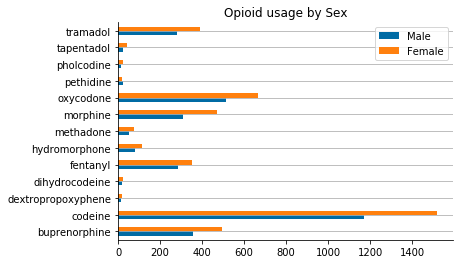

In [13]:
maleOpioids=OpioidEpisodes[OpioidEpisodes["Sex"]=='M']['Opioid'].value_counts().sort_index()
femaleOpioids=OpioidEpisodes[OpioidEpisodes["Sex"]=='F']['Opioid'].value_counts().sort_index()
OpioidIndex=OpioidEpisodes['Opioid'].value_counts().sort_index().index.tolist()

df = pd.DataFrame({'Male': maleOpioids,
                   'Female': femaleOpioids}, 
                   index=OpioidIndex)

plt.style.use('tableau-colorblind10')
ax = df.plot.barh()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.grid(b=None,axis='y')
ax.set_title('Opioid usage by Sex')

plt.show()

## Medication Strength based Queries - Leveraging AMT's Concrete Domains

All the ECL used so far have been simple subsumption queries, yet the language supports so much more expresivity! Concepts in SNOMED CT, are defined with attributes that can also be queried in ECL. AMT even supports numerical queries, such as identifying "All aspirin products with a strength greater than 200mg".

<table>
 <tr>
    <td><img src="https://ontoserver.csiro.au/axioms/Binary/http___snomed_info_sct_http___snomed_info_sct_32506021000036107_version_20190930_53798011000036101"></td>
    <td>
        <div style="text-align: left">
        ECL to identify all products with at least 200mg of aspirin, and no other ingredients
        <code>
        <30497011000036103|medicinal product|:
        {
         30364011000036101|has Australian BoSS|=1817011000036100|aspirin|,
         700000111000036105|Strength| >= #200,
         177631000036102|has unit|=700000801000036102|mg/each|
        }
       ,[1..1] 700000081000036101|has intended active ingredient|=ANY
        </code>
        </div>        
   </td>
 </tr>
</table>

The use of concrete domains in AMT is currently unique to the australian extension, though has been available for about 6 years. Ontoserver, also supports ECL queries against this property.

Below we'll perform 3 ECL queries for "Low Dose (<200mg)", "High Dose (200mg or greater)" or "Combination (other ingredients)" Aspirin products. In this example, the matching entries are counted, rather than specifically labeled again.

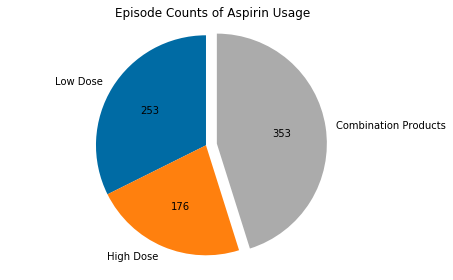

In [14]:
lowDoseAspirinProductsECL= '<30497011000036103:{30364011000036101=1817011000036100,700000111000036105 < #200,177631000036102=700000801000036102},[1..1] 700000081000036101=*'
HighDoseAspirinProductsECL='<30497011000036103:{30364011000036101=1817011000036100,700000111000036105 >= #200,177631000036102=700000801000036102},[1..1] 700000081000036101=*'
CombinationAspirinProductsECL='<21719011000036107:[2..*] 700000081000036101=*'

#Doing something different this time...
#Rather than inplace labeling the dataframe. The ECL Set filters are applied, and the rows are counted.
lowDoseEpisodeCount=codeSet.loc[codeSet["Medication"].isin(PopulateSetWithECL(lowDoseAspirinProductsECL))].shape[0]
HighDoseEpisodesCount=codeSet.loc[codeSet["Medication"].isin(PopulateSetWithECL(HighDoseAspirinProductsECL))].shape[0]
CombinationEpisodesCount=codeSet.loc[codeSet["Medication"].isin(PopulateSetWithECL(CombinationAspirinProductsECL))].shape[0]

#Illustrate the results with a Pie Chart
labels = 'Low Dose', 'High Dose', 'Combination Products'
sizes = [lowDoseEpisodeCount,HighDoseEpisodesCount,CombinationEpisodesCount]
fig, ax = plt.subplots()
ax.pie(sizes, explode=(0, 0, 0.1), labels=labels,
       autopct=lambda p: '{:.0f}'.format((p/100)*sum(sizes)),
        shadow=False, startangle=90)
ax.axis('equal')
ax.set_title('Episode Counts of Aspirin Usage')
plt.tight_layout()
plt.savefig("AspirinUsage.svg",transparent=True)
plt.show()

## Conclusion
SNOMED CT's primary purpose is to support clinicians recording clinical notes in an unambiguous way, that can safely exchanged between systems. It's structure however, allows a range of dynamic secondary purposes. Analysis can be tailored to gain insights specific to your requirements and usecases (rather than being locked in to those determined by the code system creators).

If you have any questions, get in touch. I also blog at [snoyowie.com](https://snoyowie.com/), that I very occasionally ramble on.